In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# veride okunamayan karakterleri okutmak için encoding
df = pd.read_csv(r"C:\Users\ASUS\Desktop\Bitirme\2-encoding_analysis\encoded_data.csv") 

df.head(4)

,price,m2,age,floor,total_room,district_encoded,neighbor_encoded
0,2229999,110,0,1.0,3,4.970296e+06,6.487466e+06
1,2650000,90,0,4.0,2,2.769582e+06,2.487815e+06
2,3449999,130,0,2.0,3,4.970296e+06,6.057293e+06
3,5475000,125,21,4.0,3,5.848908e+06,7.428125e+06


#### Veri Temizlenmeden R2 Değeri

In [87]:
X = df.drop(columns="price")
y = df["price"]

# Veriyi eğitim ve test olarak ayır (80% eğitim, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest modeli oluştur ve eğit
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Tahmin yap ve R² skorunu hesapla
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R² Skoru (ön işleme yapılmadan):", r2)

R² Skoru (ön işleme yapılmadan): 0.8292560478242373


### Genel Bakış

In [90]:
# Sayısal sütunların temel istatistik özeti
print("\n Sayısal Özelliklerin Temel İstatistikleri:")
print(df.describe())


 Sayısal Özelliklerin Temel İstatistikleri:
              price            m2           age         floor    total_room  \
count  1.691700e+04  16917.000000  16917.000000  16917.000000  16917.000000   
mean   8.639425e+06    123.472129     13.501626      3.424514      3.646332   
std    8.267649e+06     48.536256     14.589361      3.809870      1.911790   
min    1.200000e+06     50.000000      0.000000     -3.000000      2.000000   
25%    3.600000e+06     90.000000      1.000000      1.000000      3.000000   
50%    5.750000e+06    110.000000      8.000000      3.000000      3.000000   
75%    1.000000e+07    145.000000     25.000000      4.000000      4.000000   
max    6.000000e+07    350.000000    340.000000     24.000000    165.000000   

       district_encoded  neighbor_encoded  
count      1.691700e+04      1.691700e+04  
mean       8.639425e+06      8.639425e+06  
std        5.089616e+06      6.233915e+06  
min        2.769582e+06      1.957914e+06  
25%        4.970296e+06

**gerçekçi olmayan değerler --> age ve total_room max'ları göze çarpıyor**

### Korelasyon Haritası

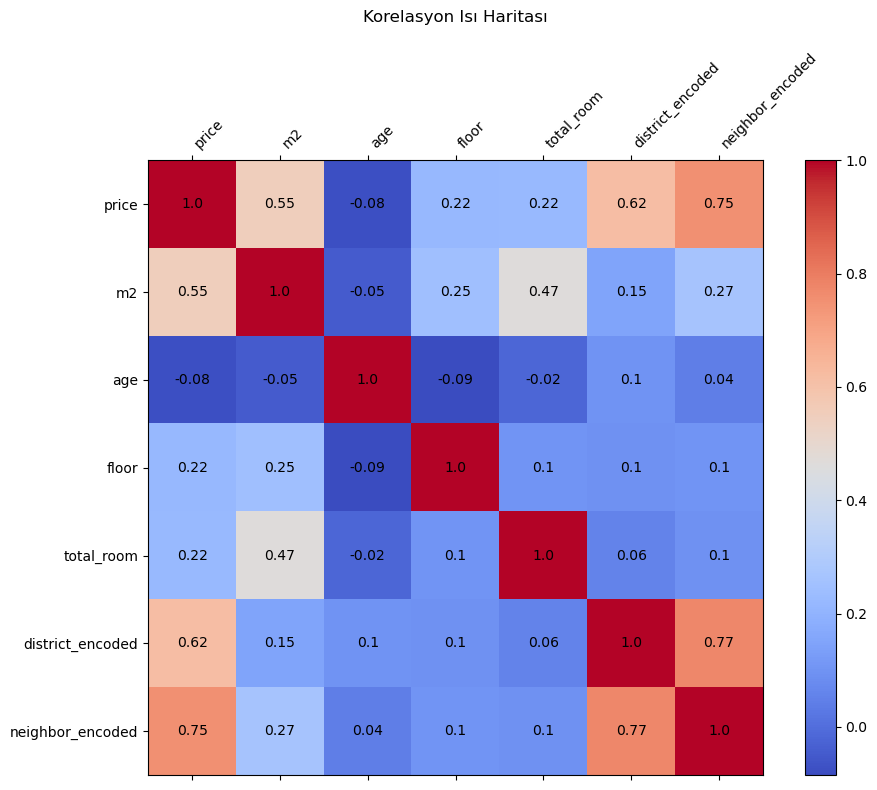

In [94]:
# Veri ile ilgili analiz kısmında kullanılacak

corr = df.corr(numeric_only=True)

# Matplotlib ile heatmap çizimi
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr, cmap='coolwarm')  # renk haritası

# Renk çubuğu (colorbar)
fig.colorbar(cax)

# Eksen etiketlerini ayarla
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='left')
ax.set_yticklabels(corr.columns)

# Sayısal değerleri hücrelerin içine yaz
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        value = round(corr.iloc[i, j], 2)
        ax.text(j, i, str(value), va='center', ha='center', color='black')

plt.title("Korelasyon Isı Haritası", pad=20)
plt.tight_layout()
plt.show()

Multicollinearity riski düşük ama district_encoded ve neighbor_encoded çiftine dikkat edilmeli. --> VIF Analizi

## Box Plot İncelemesi

Boxplotlar, bir değişkenin dağılımını, medyanını, çeyreklerini ve uç değerlerini görsel olarak analiz etmemizi sağlar.

Outlier tespiti gibi konularda çok kullanışlıdır.

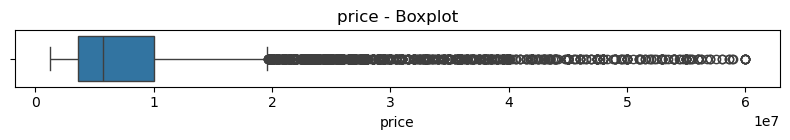

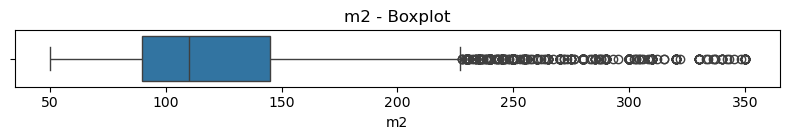

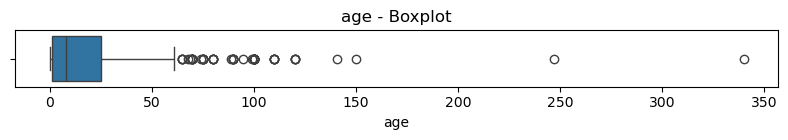

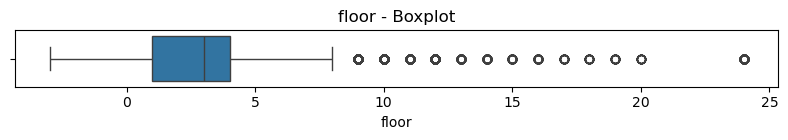

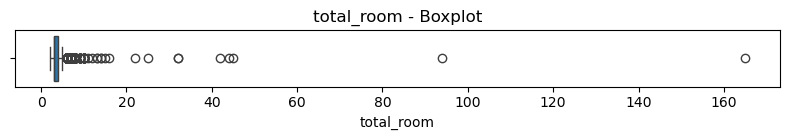

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sayısal sütunları tanımla
numerical_columns = ['price', 'm2', 'age', 'floor', 'total_room']

# Her sayısal değişken için boxplot çiz
for col in numerical_columns:
    plt.figure(figsize=(8, 1.5))           # Geniş yatay kutu grafiği
    sns.boxplot(x=df[col], orient="h")     # Yatay boxplot
    plt.title(f"{col} - Boxplot")          # Başlık
    plt.tight_layout()
    plt.show()

### price

Kutudan sonra gelen çok sayıda nokta: yüksek uç değerler (lüks konutlar gibi)

Fiyat verisi sağa çarpık ve uç değerlere sahip. Modelleme yaparken log dönüşümü düşünülmeli. Ayrıca bu uç değerler, modelin tahminlerini bozabilir.

### m2

Veride büyük evler az sayıda ama çok etkili. İsteğe bağlı olarak 250+ m² değerleri temizleyebilirsin (toplu konutlar, villa vb. olabilir).

### age

Binaların çoğu yeni, ancak arada çok eski (yüz yıllık) yapılar var. Bunlar gerçekten tarihi yapıysa modelde kalsın ama veri hatasıysa çıkarılmalı.

### floor

Zaten düzenlemeyi yapmıştık normal gözüküyor

### total_room 

10, 20 odadan sonrası için outlier denilebilir

### Outlier Temizliği

In [135]:
# Toplam satır sayısı
total_rows = df.shape[0]

# age > 70
count_age_over_70 = df[df["age"] > 70].shape[0]
print("Yaşı 70 üzeri ev sayısı:", count_age_over_70)

# m2 > 300
count_m2_over_300 = df[df["m2"] > 300].shape[0]
print("300 m² üzeri ev sayısı:", count_m2_over_300)

# total_room > 30
count_room_over_30 = df[df["total_room"] > 30].shape[0]
print("Oda sayısı 30'dan büyük ev sayısı:", count_room_over_30)

# Üç koşuldan herhangi birine uyan kayıtlar (birleşik ve tekrarsız)
combined_outliers = df[
    (df["age"] > 70) |
    (df["m2"] > 300) |
    (df["total_room"] > 30)
]

total_outliers = combined_outliers.shape[0]
percentage_outliers = (total_outliers / total_rows) * 100

print("Toplam çıkarılacak kayıt sayısı (tekrarsız):", total_outliers)
print(f"Bu kayıtlar veri setinin %{percentage_outliers:.2f}'sini oluşturuyor.")


Yaşı 70 üzeri ev sayısı: 51
300 m² üzeri ev sayısı: 95
Oda sayısı 30'dan büyük ev sayısı: 7
Toplam çıkarılacak kayıt sayısı (tekrarsız): 153
Bu kayıtlar veri setinin %0.90'sini oluşturuyor.


In [140]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

print("R² Skoru (ön işleme yapılmadan): 0.8292560478242373")
def evaluate_model(df, condition, description):
    # Veriyi filtrele
    df_filtered = df[condition]
    
    # price dışındaki sütunları X, price'ı y olarak ayır
    X = df_filtered.drop(columns="price")
    y = df_filtered["price"]

    # Veriyi eğitim ve test olarak ayır
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modeli eğit
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Tahmin ve skor
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f"R² Skoru ({description}):", r2)


# Farklı filtrelerle modeli değerlendir
evaluate_model(df, df["age"] <= 70, "sadece age > 70 çıkarıldı")
evaluate_model(df, df["m2"] <= 300, "sadece m2 > 300 çıkarıldı")
evaluate_model(df, df["total_room"] <= 30, "sadece total_room > 30 çıkarıldı")
evaluate_model(df, (df["age"] <= 70) & (df["m2"] <= 300) & (df["total_room"] <= 30),
               "age > 70, m2 > 300, total_room > 30 çıkarıldı")


R² Skoru (ön işleme yapılmadan): 0.8292560478242373
R² Skoru (sadece age > 70 çıkarıldı): 0.8257033665792088
R² Skoru (sadece m2 > 300 çıkarıldı): 0.8173800946806786
R² Skoru (sadece total_room > 30 çıkarıldı): 0.8380816144842884
R² Skoru (age > 70, m2 > 300, total_room > 30 çıkarıldı): 0.8631574359315015


In [146]:
df_next = df[(df["age"] <= 70) & (df["m2"] <= 300) & (df["total_room"] <= 30)]
df_next.shape

(16764, 7)

# IQR, Z-Score, Winsorition

# IQR


In [155]:
# IQR yöntemiyle aykırı değer sayısını hesaplayan fonksiyon
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers)

# İncelenecek sayısal sütunlar
numeric_columns = ["price", "m2", "age", "floor", "total_room"]

# Her sütun için IQR yöntemiyle outlier sayısını bul
iqr_outlier_counts = {col: detect_outliers_iqr(df, col) for col in numeric_columns}

# Sonuçları yazdır
for col, count in iqr_outlier_counts.items():
    print(f"{col} değişkeninde IQR ile tespit edilen aykırı değer sayısı: {count}")


price değişkeninde IQR ile tespit edilen aykırı değer sayısı: 1588
m2 değişkeninde IQR ile tespit edilen aykırı değer sayısı: 766
age değişkeninde IQR ile tespit edilen aykırı değer sayısı: 63
floor değişkeninde IQR ile tespit edilen aykırı değer sayısı: 1711
total_room değişkeninde IQR ile tespit edilen aykırı değer sayısı: 1108


# Z-Score

In [158]:
from scipy.stats import zscore
import numpy as np

# Z-score yöntemiyle outlier sayısını hesaplayan fonksiyon
def detect_outliers_zscore(data, column, threshold=3):
    z_scores = zscore(data[column])
    outliers = np.where(np.abs(z_scores) > threshold)[0]
    return len(outliers)

# İncelenecek sayısal sütunlar
numeric_columns = ["price", "m2", "age", "floor", "total_room"]

# Her sütun için Z-score yöntemiyle outlier sayısını bul
zscore_outlier_counts = {col: detect_outliers_zscore(df, col) for col in numeric_columns}

# Sonuçları yazdır
for col, count in zscore_outlier_counts.items():
    print(f"{col} değişkeninde Z-score ile tespit edilen aykırı değer sayısı: {count}")


price değişkeninde Z-score ile tespit edilen aykırı değer sayısı: 423
m2 değişkeninde Z-score ile tespit edilen aykırı değer sayısı: 306
age değişkeninde Z-score ile tespit edilen aykırı değer sayısı: 87
floor değişkeninde Z-score ile tespit edilen aykırı değer sayısı: 267
total_room değişkeninde Z-score ile tespit edilen aykırı değer sayısı: 28


### Winsorisiton

In [188]:
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Tek listeyle tüm oranları test edelim
winsor_limits = [0.01, 0.03, 0.05, 0.07]

# Her winsor oranı için R² skorunu hesapla
for limit in winsor_limits:
    df_test = df.copy()  # her iterasyonda temiz kopya

    # Belirlenen sütunlara winsorize uygula
    for col in ["price", "m2", "total_room"]:
        df_test[col] = winsorize(df_test[col], limits=[limit, limit])

    # Modelleme
    X = df_test.drop(columns="price")
    y = df_test["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    print(f"R² Skoru sade df (%{int(limit*100)} Winsorization): {r2:.6f}")


R² Skoru sade df (%1 Winsorization): 0.846035
R² Skoru sade df (%3 Winsorization): 0.861451
R² Skoru sade df (%5 Winsorization): 0.867626
R² Skoru sade df (%7 Winsorization): 0.866924


In [198]:
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Tek listeyle tüm oranları test edelim
winsor_limits = [0.01, 0.03, 0.05, 0.07]

# Her winsor oranı için R² skorunu hesapla
for limit in winsor_limits:
    df_test = df_next.copy()  # her iterasyonda temiz kopya

    # Belirlenen sütunlara winsorize uygula
    for col in ["m2", "total_room","age"]:
        df_test[col] = winsorize(df_test[col], limits=[limit, limit])

    # Modelleme
    X = df_test.drop(columns="price")
    y = df_test["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    print(f"R² Skoru df_next (%{int(limit*100)} Winsorization): {r2:.6f}")


R² Skoru df_next (%1 Winsorization): 0.873423
R² Skoru df_next (%3 Winsorization): 0.872410
R² Skoru df_next (%5 Winsorization): 0.872541
R² Skoru df_next (%7 Winsorization): 0.870547


# IQR


In [204]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np

# IQR outlier temizleme fonksiyonu (esnek k)
def remove_outliers_iqr(df, column, k):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Denenecek k değerleri
k_values = np.arange(1.0, 4.2, 0.3)

# IQR uygulanacak sütunlar
columns = ["price", "m2", "total_room", "age"]

# Sonuçları tut
for k in k_values:
    df_iqr = df.copy()
    for col in columns:
        df_iqr = remove_outliers_iqr(df_iqr, col, k)

    X = df_iqr.drop(columns="price")
    y = df_iqr["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    print(f"R² Skoru (IQR katsayısı k={k:.1f}): {r2:.6f}")


R² Skoru (IQR katsayısı k=1.0): 0.767606
R² Skoru (IQR katsayısı k=1.3): 0.776516
R² Skoru (IQR katsayısı k=1.6): 0.791424
R² Skoru (IQR katsayısı k=1.9): 0.799278
R² Skoru (IQR katsayısı k=2.2): 0.807761
R² Skoru (IQR katsayısı k=2.5): 0.815577
R² Skoru (IQR katsayısı k=2.8): 0.836686
R² Skoru (IQR katsayısı k=3.1): 0.830816
R² Skoru (IQR katsayısı k=3.4): 0.828864
R² Skoru (IQR katsayısı k=3.7): 0.841929
R² Skoru (IQR katsayısı k=4.0): 0.845453


# Z - Score

In [210]:
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np

# Denenecek z-score eşikleri
z_thresholds = [2.0, 2.5, 3.0, 3.5]

# Sütunlar
columns = ["price", "m2", "total_room", "age"]

# Sonuçları tut
for z_thresh in z_thresholds:
    df_z = df.copy()
    
    for col in columns:
        z = np.abs(zscore(df_z[col]))
        df_z = df_z[z < z_thresh]

    # Modelleme
    X = df_z.drop(columns="price")
    y = df_z["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f"R² Skoru (Z-score threshold = {z_thresh}): {r2:.6f}")


R² Skoru (Z-score threshold = 2.0): 0.803909
R² Skoru (Z-score threshold = 2.5): 0.835104
R² Skoru (Z-score threshold = 3.0): 0.836189
R² Skoru (Z-score threshold = 3.5): 0.831031


| Z-score Eşiği | R² Skoru     | Kayıp/Temizlik Dengesi    | Yorum                                             |
| ------------- | ------------ | ------------------------- | ------------------------------------------------- |
| **2.0**       | 0.8039       | Çok sıkı (aşırı temizlik) | ⚠️ Performans düştü — fazla bilgi kaybı           |
| **2.5**       | 0.8351       | Dengeli temizlik          | 👍 Güçlü sonuç                                    |
| **3.0**       | **0.8362** ✅ | En iyi denge              | 🏆 En yüksek skor                                 |
| **3.5**       | 0.8310       | Temizlik azaldı           | 🔁 Skor hafif düştü — uç değerler kalmaya başladı |


| Yöntem                 | En İyi Sonuç (R²)   |
| ---------------------- | ------------------- |
| ✅ Winsorize            | **0.8748** (en iyi) |
| Z-Score                | 0.8362              |
| IQR                    | 0.8455              |
| Z < 3.0 veya IQR < 2.5 | 0.76–0.82 arası ❌   |


In [214]:
from scipy.stats.mstats import winsorize
import pandas as pd

# Orijinal veriyi oku (zaten df varsa bunu atla)
# df = pd.read_csv("encoded_data.csv")

# 3 filtreleme uygulanmış hali → df_next2
df_next2 = df[(df["age"] <= 70) & (df["m2"] <= 300) & (df["total_room"] <= 30)].copy()

# Winsorize edilecek sütunlar
columns_to_winsorize = ["price", "m2", "total_room", "age"]

# %1 alt/üst kırpma (winsorization)
for col in columns_to_winsorize:
    df_next2[col] = winsorize(df_next2[col], limits=[0.01, 0.01])

# CSV olarak kaydet
df_next2.to_csv("df_next2_winsorized.csv", index=False)

print("df_next2 başarıyla oluşturuldu ve kaydedildi: df_next2_winsorized.csv")


df_next2 başarıyla oluşturuldu ve kaydedildi: df_next2_winsorized.csv
